# Setup

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers

from utils.distribution_utils import q

from utils.qcd_utils import running_coupling   


# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


In [1]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

NameError: name 'jax' is not defined

# Problem Definition

In [ ]:
OPAL_DATA = np.array([
    [0.004849660523763337, 1.2754409769335133],
    [0.014742967992240535, 12.917232021709632],
    [0.02521823472356935, 18.534599728629576],
    [0.03491755577109602, 13.568521031207597],
    [0.04461687681862268, 9.660786974219809],
    [0.05470417070805042, 7.327001356852101],
    [0.0649854510184287, 5.671641791044777],
    [0.0748787584869059, 4.586160108548167],
    [0.08457807953443258, 3.7177747625508815],
    [0.0946653734238603, 3.066485753052916],
    [0.10494665373423859, 2.6594301221166887],
    [0.11483996120271578, 2.2523744911804577],
    [0.124733268671193, 1.9538670284938924],
    [0.13501454898157125, 1.6282225237449133],
    [0.14490785645004847, 1.4111261872455891],
    [0.15499515033947622, 1.2754409769335133],
    [0.16488845780795341, 1.1397557666214375],
    [0.17478176527643063, 0.9769335142469444],
    [0.1850630455868089, 0.8683853459972894],
    [0.1949563530552861, 0.7869742198100411],
    [0.20387972841901064, 0.678426051560379],])

OPAL_DATA_UPEPR = np.array([
    [0.0052376333656644, 1.5196743554952512],
    [0.015130940834141612, 13.405698778833106],
    [0.025024248302618804, 19.240162822252373],
    [0.035111542192046555, 13.839891451831749],
    [0.04519883608147429, 9.8236092265943],
    [0.0550921435499515, 7.435549525101765],
    [0.06517943743937923, 5.780189959294436],
    [0.07507274490785644, 4.694708276797829],
    [0.08516003879728418, 3.7991858887381262],
    [0.0950533462657614, 3.1478968792401645],
    [0.10514064015518912, 2.7408412483039335],
    [0.11522793404461687, 2.279511533242875],
    [0.12512124151309406, 2.008141112618727],
    [0.1352085354025218, 1.709633649932158],
    [0.14490785645004847, 1.492537313432834],
    [0.15518913676042673, 1.329715061058348],
    [0.16508244422890395, 1.194029850746265],
    [0.17497575169738114, 1.0583446404341927],
    [0.1850630455868089, 0.9226594301221169],
    [0.1949563530552861, 0.8412483039348722],
    [0.20387972841901064, 0.7055630936227963],])


OPAL_ERRORS = jnp.abs(OPAL_DATA_UPEPR[:,1] - OPAL_DATA[:,1])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.54999703 0.54999703 0.54999703
0.108874775 0.1405201 0.15090214
0.5978424 0.5978424 0.5978424
0.059880804 0.07728563 0.08299573


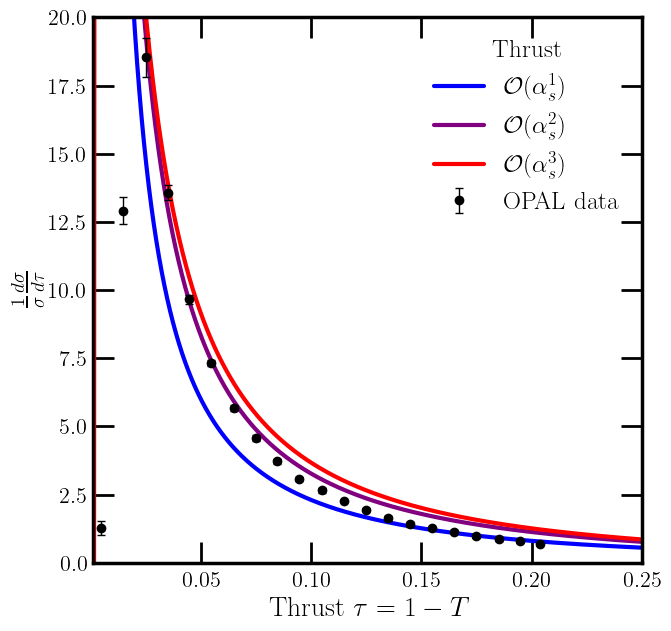

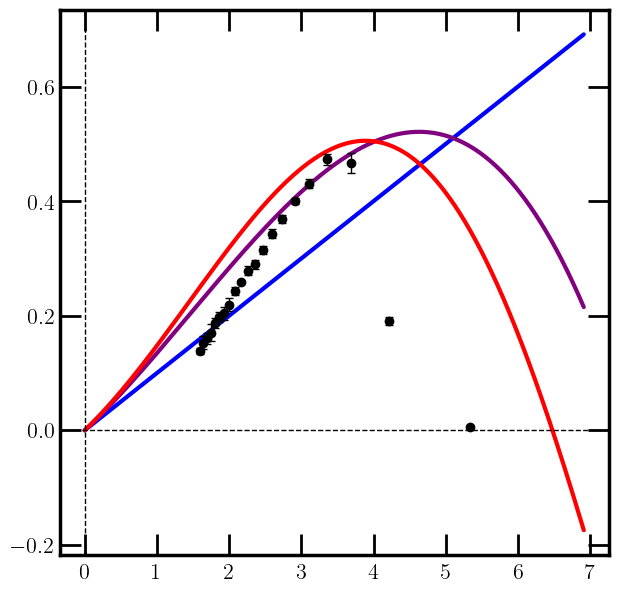

In [ ]:

# Define the t function as it relates to x. 
shift =  1 #0.1047236225 #0.45
def t_from_x(x):
    return jnp.log(1/x * shift)

def x_from_t(t):
    return jnp.exp(-t) * shift



# Define the FO distribution p(t | alpha) as either a function of t or x

C_F = 4/3
C_A = 3
T_F = 1/2
n_f = 5
zeta_3 = 1.20205690315959
zeta_5 = 1.03692775514337
c_2CF_S = 58.00 # +-2
c_2CA_S = -60 # +- 1
c_2nf_S = 43.00 # +- 1
mz = 91.1876


order = 1

def p_x_1(x, alpha, params):
    return p_x_order(x, alpha, 1)

def p_x_2(x, alpha, params):
    return p_x_order(x, alpha, 2)

def p_x_3(x, alpha, params):
    return p_x_order(x, alpha, 3)

def p_x_order(x, alpha, order ):

    scale = 91.1876 * x
    alpha_s = running_coupling(alpha, mz, mz)


    funcs = [DA, DB, DC]
    alpha_bar = alpha_s / (2 * np.pi)
    
    res = jnp.zeros_like(x)

    for o in range(order):
        res += alpha_bar**(o + 1) * funcs[o](x)
    return res


def DA(x):
    return 1/x * (C_F) * (-4 * jnp.log(x)  - 3)

def DB(x):

    L = jnp.log(x)
    term1 = C_F**2 * (8*L**3 + 18*L**2 + (13 - 4*np.pi**2)*L  + 9/4 - 2*np.pi**2 + 4*zeta_3)
    term2 = C_F * T_F * n_f * (-4 * L**2 + 22/9 *L + 5)
    term3 = C_F * C_A * (11 * L**2 + (-169 / 18 + 2*np.pi**2 /3) * L - 57/4 + 6*zeta_3)

    return 1/x * (term1 + term2 + term3)


def DC(x):
    pi2 = jnp.pi**2
    pi4 = jnp.pi**4
    L = jnp.log(x)
    prefactors = jnp.array([1*C_F**3, 1*C_F**2 * n_f * T_F,  1*C_F * n_f**2 * T_F**2, 1*C_F * C_A**2, 1*C_F**2 * C_A, C_A * C_F * n_f * T_F])

    # From L^5 to L^0
    terms = jnp.array([[-8, -30, (-44 + 40*np.pi**2 / 3), (-88*zeta_3 + 24*np.pi**2 - 27), (-c_2CF_S -96*zeta_3 + 53*pi2**2/90 + 79*pi2/6 - 17/2), (16*pi2*zeta_3 - 39*zeta_3 - 132*zeta_5 + 19*pi2**2/120 + 5/8*pi2 - 47/8 - 3/4 *c_2CF_S)], # C_F^3
             [0, 40/3, 56/9, (-43 - 28*pi2/3), (-c_2nf_S + 664*zeta_3/9 + 164*pi2/27 - 1495/81), (274 * zeta_3 / 9 - 31 * pi4 / 45 + 56*pi2/9 + 1511/108 + 2/3 * c_2CF_S - 3/4 * c_2nf_S) ],
             [0.0, 0.0, -112/27, 68/9, (140/81 + 16 * pi2 / 27), (-176 * zeta_3 / 27 - 64*pi2/81 - 3598/243 + 2*c_2nf_S/3)],
             [0.0, 0.0, -847/27, (3197/36 - 11*pi2/3), (22 * zeta_3 - 11*pi4/45 + 85*pi2/9 - 11323/324), (-10*zeta_5 + 361*zeta_3/27 + 541*pi4/540 - 739*pi2/81 - 77099/486 - 11/6 * c_2CA_S)],
             [0.0, -110/3, (-58/9 - 8*pi2/3), (-36*zeta_3 + 68*pi2/3 + 467/4), (-2870*zeta_3/9 + 173*pi4/90 - 625*pi2/27 + 29663/324 - c_2CA_S), (-30 * zeta_5 - 1861*zeta_3/18 + 973*pi4/360 - 317*pi2/18 - 49/27 - 11/6 * c_2CF_S - 3/4 * c_2CA_S)],
             [0.0, 0.0, 616/27, 4*pi2/3 - 512/9, (8*zeta_3 - 128*pi2/27 + 673/81), (608*zeta_3/27 - 10*pi4/27 + 430*pi2/81 + 24844/243 - 11/6*c_2nf_S + 2/3 * c_2CA_S)]
    ])



    Ls = jnp.array([L**5, L**4, L**3, L**2, L**1, L**0])
    res = prefactors[:, None] * terms
    res = res * Ls[None, :]
    res = res.sum()
    return 1/x * res
    # return 1/x * 

vmapped_p_x_1 = jax.vmap(p_x_1, in_axes=(0, None, None))
vmapped_p_x_2 = jax.vmap(p_x_2, in_axes=(0, None, None))
vmapped_p_x_3 = jax.vmap(p_x_3, in_axes=(0, None, None))

test_xs = jnp.linspace(0.25, 0.55, 100000)
max_nonzero_x_1 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_1(test_xs, 0.118, None)))-1]
max_nonzero_x_2 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_2(test_xs, 0.118, None)))-1]
max_nonzero_x_3 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_3(test_xs, 0.118, None)))-1]

print(max_nonzero_x_1, max_nonzero_x_2, max_nonzero_x_3)
print(p_x_1(max_nonzero_x_1, 0.118, None), p_x_2(max_nonzero_x_2, 0.118, None), p_x_3(max_nonzero_x_3, 0.118, None))
print(t_from_x(max_nonzero_x_1), t_from_x(max_nonzero_x_2), t_from_x(max_nonzero_x_3))

def p_t_1(t, alpha, params):
    return p_x_1(x_from_t(t), alpha, params) * jnp.abs(x_from_t(t))

def p_t_2(t, alpha, params):
    return p_x_2(x_from_t(t), alpha, params) * jnp.abs(x_from_t(t))


def p_t_3(t, alpha, params):
    return p_x_3(x_from_t(t), alpha, params) * jnp.abs(x_from_t(t))

print(p_t_1(t_from_x(max_nonzero_x_1), 0.118, None), p_t_2(t_from_x(max_nonzero_x_2), 0.118, None), p_t_3(t_from_x(max_nonzero_x_3), 0.118, None))

vmapped_p_t_1 = jax.vmap(p_t_1, in_axes=(0, None, None))
vmapped_p_t_2 = jax.vmap(p_t_2, in_axes=(0, None, None))
vmapped_p_t_3 = jax.vmap(p_t_3, in_axes=(0, None, None))

vmapped_ps = [vmapped_p_t_1, vmapped_p_t_2, vmapped_p_t_3]

# def p_ideal(t, alpha, params):
#     alpha_bar = alpha #* 4/3 / jnp.pi
#     return jnp.exp(-0.5 * alpha_bar * t**2 + 0.5 * alpha_bar**2 * t **4 - 0.5 * alpha_bar**3 * t**6) * (alpha_bar * t - 2 * alpha_bar**2 * t**3 + 3 * alpha_bar**3 * t**5)


# # Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
# def p_t(t, alpha, params):
#     alpha_bar = alpha #* 4/3 / jnp.pi
#     return alpha_bar * t #-  2.5 * alpha_bar**2 * t**3

# p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
# p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

# def p_x(x, alpha, params):
#     return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-3, 0, 10000)
ts = t_from_x(xs)

fig, ax = newplot("full")
# ax.plot(xs, p_x_idea(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, vmapped_p_x_1(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^1)$", color = "blue")
ax.plot(xs, vmapped_p_x_2(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^2)$", color = "purple")
ax.plot(xs, vmapped_p_x_3(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")
ax.errorbar(OPAL_DATA[:,0], OPAL_DATA[:,1], yerr=OPAL_ERRORS, fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)



# ax.set_xscale("log")
# ax.set_yscale("log")

plt.legend(title = "Thrust")

plt.xlim(0.001, 0.25  / shift)
plt.ylim(0.0, 20)

plt.xlabel(r"Thrust $\tau = 1 - T$")
plt.ylabel(r"$\frac{1}{\sigma} \frac{d\sigma}{d\tau}$")


fig, ax = newplot("full")
ax.plot(ts, vmapped_p_t_1(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^1)$", color = "blue")
ax.plot(ts, vmapped_p_t_2(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^2)$", color = "purple")
ax.plot(ts, vmapped_p_t_3(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")
ax.errorbar(t_from_x(OPAL_DATA[:,0]), OPAL_DATA[:,1] * OPAL_DATA[:,0], yerr=OPAL_ERRORS * OPAL_DATA[:,0], fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)

ax.axhline(0, color = "black", linestyle = "--", lw = 1)
ax.axvline(0, color = "black", linestyle = "--", lw = 1)


In [5]:
from utils.function_utils import taylor_expand_2d, polynomial_sum, polynomial_multiply, polynomial_power, print_polynomial, integrate_taylor_polynomial, derivative_t_polynomial, reduce_order, log_match


def matching_coeffs(p_t, M, N, t_min = 0.0):
 
    p_mn = taylor_expand_2d(p_t, t_min, 0.0, M, N)
    P_mn = integrate_taylor_polynomial(p_mn)

    # print_polynomial(p_mn)
    # print_polynomial(P_mn)
    # print("")


    

    # Divide out the lowest order term of p_mn
    p_mn_reduced, m_star, n_star, p_star = reduce_order(p_mn)
    p_mn_reduced = p_mn_reduced.at[0, 0].set(0.0)

    p_matched = log_match(-p_mn_reduced, M - m_star, N-n_star)
    P_matched = log_match(P_mn, M, N) 


    # print(m_star, n_star, p_star)

    # print("p_matched")
    # print_polynomial(p_matched)
    # print("P_matched")
    # print_polynomial(P_matched)
    # print("")


    g_mn = polynomial_sum([-p_matched, P_matched])
    g_star = jnp.zeros((M+1, N+1))
    g_star = g_star.at[m_star, n_star].set(-p_star)

    return g_mn[:,:N], g_star



g_mn, g_star = matching_coeffs(p_t_2, 3, 3, 0.0)
print("g_mn")
print_polynomial(g_mn)
print("g_star")
print_polynomial(g_star)

/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 1.50e+00 c_1,1 = 1.87e+00 c_1,2 = 1.49e-07 
c_2,0 = -1.12e+00 c_2,1 = -2.80e+00 c_2,2 = -4.78e-01 
c_3,0 = 0.00e+00 c_3,1 = 0.00e+00 c_3,2 = 0.00e+00 
g_star
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 c_0,3 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = -8.49e-01 c_1,2 = 0.00e+00 c_1,3 = 0.00e+00 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 c_2,3 = 0.00e+00 
c_3,0 = 0.00e+00 c_3,1 = 0.00e+00 c_3,2 = 0.00e+00 c_3,3 = 0.00e+00 


In [6]:
print(taylor_expand_2d(p_t_2, 0.0, 0.0, 4, 4))

/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


[[ 0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
  -0.0000000e+00]
 [ 0.0000000e+00  8.4882635e-01  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  1.2705982e+00  1.5873650e+00 -3.6025295e-01
   1.2883653e-07]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]]


In [7]:
ps = [p_t_1, p_t_2, p_t_3]
order = len(ps)


t = jnp.linspace(0, 20, 1000)


num_trials = 5
colors = []

factorials = np.zeros((4,4))
for i in range(factorials.shape[0]):
    for j in range(factorials.shape[1]):
        factorials[i, :] = math.factorial(i) * math.factorial(j)



data = np.zeros((order, t.shape[0], num_trials))

for o in range(order):

    print(f"Order {o+1}")

    for trial in range(num_trials):

        seed = jax.random.PRNGKey(trial)

        g_mn_matched, g_star = matching_coeffs(ps[o], o+1, o+1, t_min = 0.0)
        print(g_mn_matched)
        print(g_star)
    
        
        g_mn = jax.random.normal(seed, factorials.shape)  / factorials * 0
        g_mn = g_mn.at[:o+2, :].set(0)
        g_mn = g_mn.at[:o+2, :o+1].set(g_mn_matched)

        data[o, :, trial] = vmapped_q(t, 0.118, g_star, g_mn, 0.0)



Order 1
[[0.]
 [0.]]
[[ 0.          0.        ]
 [ 0.         -0.84882635]]


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


[[0.]
 [0.]]
[[ 0.          0.        ]
 [ 0.         -0.84882635]]
[[0.]
 [0.]]
[[ 0.          0.        ]
 [ 0.         -0.84882635]]
[[0.]
 [0.]]
[[ 0.          0.        ]
 [ 0.         -0.84882635]]
[[0.]
 [0.]]
[[ 0.          0.        ]
 [ 0.         -0.84882635]]
Order 2
[[0.        0.       ]
 [1.4968883 1.8700705]
 [0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.84882635  0.        ]
 [ 0.          0.          0.        ]]


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


[[0.        0.       ]
 [1.4968883 1.8700705]
 [0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.84882635  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.       ]
 [1.4968883 1.8700705]
 [0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.84882635  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.       ]
 [1.4968883 1.8700705]
 [0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.84882635  0.        ]
 [ 0.          0.          0.        ]]
[[0.        0.       ]
 [1.4968883 1.8700705]
 [0.        0.       ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.84882635  0.        ]
 [ 0.          0.          0.        ]]
Order 3
[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.4968883e+00 1.8700705e+00 1.4901161e-07]
 [1.4935985e+00 4.2692137e+00 1.0294819e-01]
 [0.0000000e+00 0.0000000e+00 1.1093887e+00]]
[[ 0.          0.          0.          0.        ]
 [ 0.   

-1.0000633
-1.0000633
-1.0000633
-1.0000633
-1.0000633
-0.8003315
-0.8003315
-0.8003315
-0.8003315
-0.8003315


/tmp/ipykernel_66454/2156978914.py:21: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data[i] / xs[:,None], axis = 1)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-0.5741152
-0.5741152
-0.5741152
-0.5741152
-0.5741152


(0.01, 1000.0)

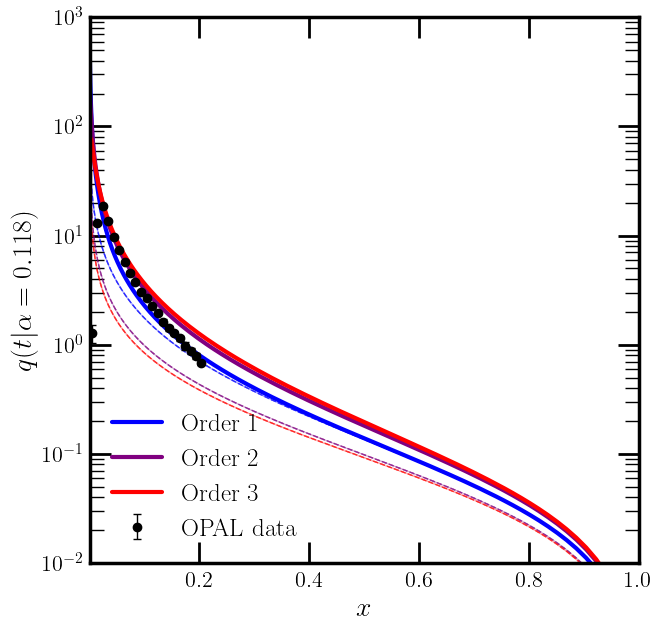

In [8]:
fig, ax = newplot("full", sharex=True)

order = 3
colors = ["blue", "purple", "red"]
xs = x_from_t(t)

for i in range(order):

    ax.plot(xs, vmapped_ps[i](t, 0.118, i) / xs, label=f"Order {i+1}", color = colors[i],)



    for trial in range(num_trials):

        ax.plot(xs, data[i, :,trial] / xs, color = colors[i], linestyle = "--", alpha = 0.05, lw = 0.5)
        # ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        # print integral
        print(jnp.trapz(np.nan_to_num(data[i, :,trial]/xs), xs))

    mean = np.nanmean(data[i] / xs[:,None], axis = 1)
    std = np.nanstd(data[i] / xs[:,None], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax.plot(xs, mean - std, color = colors[i], linestyle = "--", alpha = 0.5, lw = 1)
    ax.plot(xs, mean + std, color = colors[i], linestyle = "--", alpha = 0.5, lw = 1)
    ax.fill_between(xs, mean - std, mean + std, color = "white", alpha = 0.99, ls = "--")
    ax.fill_between(xs, mean - std, mean + std, color = colors[i], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

#     # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
#     ax[1].plot(t, (mean - std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
#     ax[1].plot(t, (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
#     ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
#     ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

#     ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
#     ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

# ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


# Plot OPAL data
ax.errorbar(OPAL_DATA[:,0], OPAL_DATA[:,1], yerr=OPAL_ERRORS, fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)

ax.legend(loc = "lower left")

# ax.set_yscale("log")

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$q(t|\alpha = 0.118)$")

ax.set_yscale("log")

plt.xlim(0.001, 1)
plt.ylim(0.01, 1e3)# ax[1].set_ylim(1/1.1, 1.1)

[       nan 0.00167313 0.00333134 0.00497456 0.00660275 0.00821583
 0.00981377 0.01139651 0.012964   0.01451621 0.01605311 0.01757465
 0.01908081 0.02057158 0.02204691 0.02350681 0.02495125 0.02638022
 0.02779373 0.02919175 0.0305743  0.03194137 0.03329298 0.03462913
 0.03594983 0.0372551  0.03854495 0.03981942 0.04107851 0.04232226
 0.0435507  0.04476386 0.04596176 0.04714446 0.04831198 0.04946438
 0.05060169 0.05172395 0.05283123 0.05392355 0.05500099 0.05606359
 0.05711141 0.05814452 0.05916296 0.0601668  0.06115611 0.06213095
 0.06309139 0.06403749 0.06496932 0.06588698 0.06679051 0.06768
 0.06855553 0.06941716 0.07026499 0.07109907 0.07191951 0.07272639
 0.07351977 0.07429978 0.07506645 0.0758199  0.07656022 0.07728748
 0.07800179 0.07870322 0.07939186 0.08006781 0.08073118 0.08138204
 0.08202048 0.08264661 0.08326051 0.08386229 0.08445203 0.08502985
 0.08559582 0.08615006 0.08669265 0.08722368 0.08774327 0.08825152
 0.0887485  0.08923434 0.08970913 0.09017296 0.09062593 0.0910681

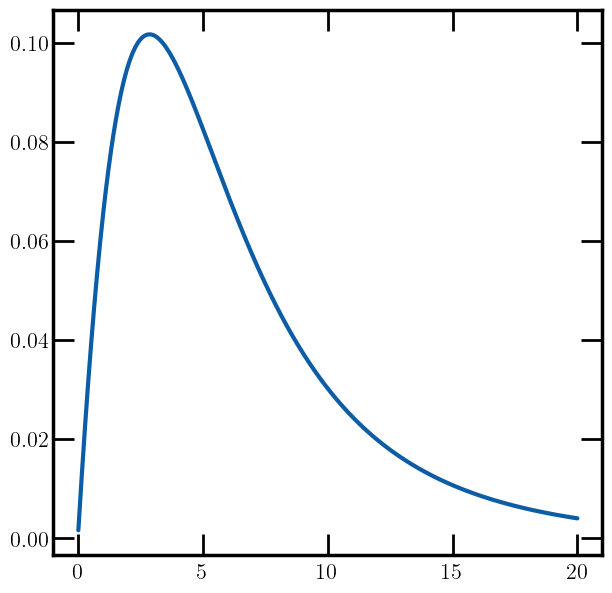

In [9]:

# plt.yscale("log")

fig, ax = newplot("full")

plt.plot(t_from_x(xs), (data[1,:,0]))

print(data[1,:,0])

# g_star = np.array([[0. ,        0. ,        0. ,       ],
#  [-0.63661975, 0.,         0.  ,      ],
#  [0.  ,       0.    ,     0.     ,   ]])
# g_mn = np.array([[ 0.  ,      -1.3333334,],
#  [ 1.3539284, -0.8272328],
#  [ 0.        ,-0.8619376]])


# xss = jnp.logspace(-3, 0, 10000)
# ttttt = vmapped_q(t_from_x(xss), 0.118, g_star, g_mn, 0.0)

# plt.plot(t_from_x(xss), (ttttt))
# ax.plot(ts, vmapped_p_t_3(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")

# ax.errorbar(t_from_x(OPAL_DATA[:,0]), OPAL_DATA[:,1] * OPAL_DATA[:,0], yerr=OPAL_ERRORS * OPAL_DATA[:,0], fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)


# Parameter Extraction

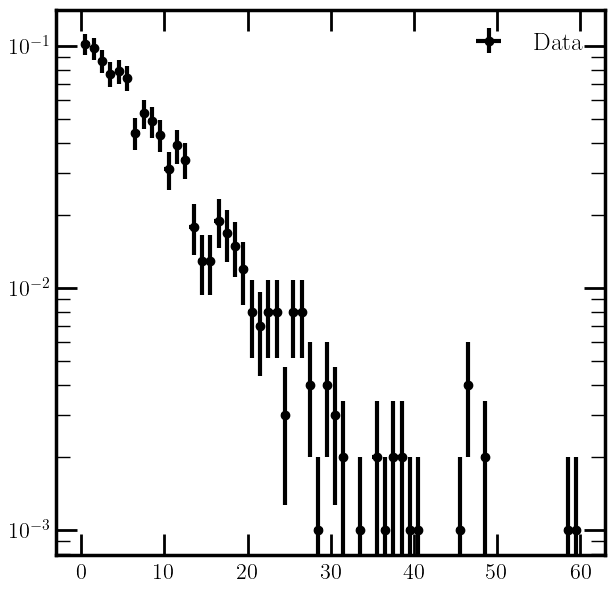

In [10]:
N_data = 1000
alpha_true = 0.118

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true

fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.legend()

plt.yscale("log")

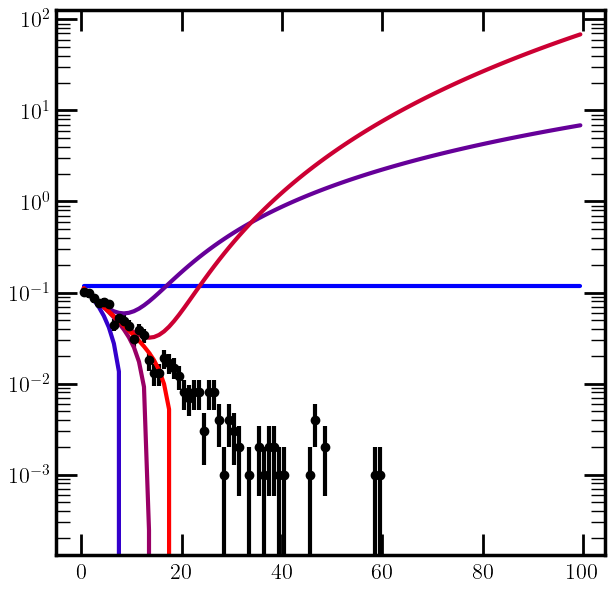

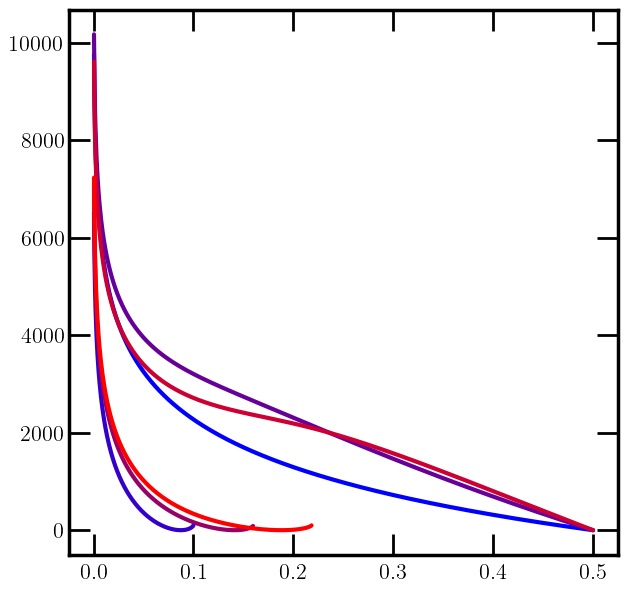

In [11]:
# Get lambda functions for FO likelihoods

def p_order_N(t, alpha, M):

    result = 0
    for i in range(M + 1):
        result += alpha  * jnp.power(-1 * alpha * t, i) / math.factorial(i)
    return result




max_M = 5


fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")



fig, ax = newplot("full")                                                                       
for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted[t_sorted < 10]


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = color)



NameError: name 'exponential_distribution' is not defined

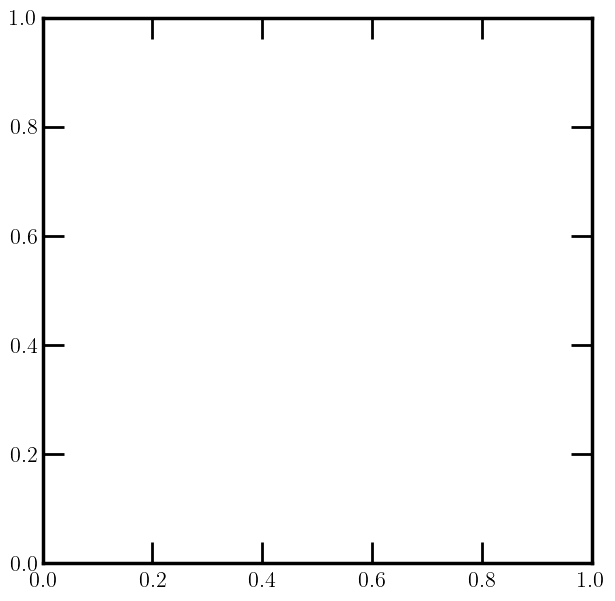

In [12]:
from scipy.optimize import minimize


num_higher_orders = 1

max_M = 5

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    # print(g_mn_matched.shape)
    # print(g_mn.shape)
    # print(i+1, i)

    g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)


    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

        # print("")
        # print(g_mn_matched.shape)
        # print(g_mn.shape)
        # print(g_mn_higher.shape)

        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    

    # Minimize likelihood function
    initial_alpha = 0.12
    initial_guess = jnp.zeros(g_mn.shape[1]+1)

    initial_guess = initial_guess.at[0].set(initial_alpha)


    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    alphas = jnp.linspace(0.11, 0.13, 250)

    def profile_minimize(alphas):
        res_partial = minimize(profile_likelihood_function, res_full.x[1:], args=(alphas), method='Nelder-Mead', options={'disp': False})
        return res_partial.fun

    likelihoods = jnp.zeros(alphas.shape)
    for j, alpha in enumerate(alphas):
        res_partial = profile_minimize(alpha)
        likelihoods = likelihoods.at[j].set(res_partial)

    likelihoods = likelihoods - res_full.fun

    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = colors[i])

    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]



    minus_one = alphas_less_than_one[0]
    plus_one = alphas_less_than_one[-2]

    # Vertical band
    ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])

    print("Order", i)
    print("Min Alpha", min_alpha)
    print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

plt.yscale("log")